In [1]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, CSVLogger
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd7 import build_model
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms
from data_generator.data_augmentation_chain_variable_input_size import DataAugmentationVariableInputSize
from data_generator.data_augmentation_chain_constant_input_size import DataAugmentationConstantInputSize
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_geometric_ops import Resize

%matplotlib inline

Using TensorFlow backend.
/userhome/2072/fyp19009/anaconda3/envs/server/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/userhome/2072/fyp19009/anaconda3/envs/server/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/userhome/2072/fyp19009/anaconda3/envs/server/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np

In [2]:
img_height = 500 # Height of the input images
img_width = 500 # Width of the input images
img_channels = 3 # Number of color channels of the input images
intensity_mean = 127.5 # Set this to your preference (maybe `None`). The current settings transform the input pixel values to the interval `[-1,1]`.
intensity_range = 127.5 # Set this to your preference (maybe `None`). The current settings transform the input pixel values to the interval `[-1,1]`.
n_classes = 1 # Number of positive classes
scales = [0.08, 0.16, 0.32, 0.64, 0.96] # An explicit list of anchor box scaling factors. If this is passed, it will override `min_scale` and `max_scale`.
aspect_ratios = [0.5, 1.0, 2.0] # The list of aspect ratios for the anchor boxes
two_boxes_for_ar1 = True # Whether or not you want to generate two anchor boxes for aspect ratio 1
steps = None # In case you'd like to set the step sizes for the anchor box grids manually; not recommended
offsets = None # In case you'd like to set the offsets for the anchor box grids manually; not recommended
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [1.0, 1.0, 1.0, 1.0] # The list of variances by which the encoded target coordinates are scaled
normalize_coords = True # Whether or not the model is supposed to use coordinates relative to the image size
mean_color = [123, 117, 104]

In [3]:
# 1: Build the Keras model

K.clear_session() # Clear previous models from memory.

model = build_model(image_size=(img_height, img_width, img_channels),
                    n_classes=n_classes,
                    mode='training',
                    l2_regularization=0.0005,
                    scales=scales,
                    aspect_ratios_global=aspect_ratios,
                    aspect_ratios_per_layer=None,
                    two_boxes_for_ar1=two_boxes_for_ar1,
                    steps=steps,
                    offsets=offsets,
                    clip_boxes=clip_boxes,
                    variances=variances,
                    normalize_coords=normalize_coords,
                    subtract_mean=intensity_mean,
                    divide_by_stddev=intensity_range)

# 2: Optional: Load some weights

#model.load_weights('./ssd7_weights.h5', by_name=True)

# 3: Instantiate an Adam optimizer and the SSD loss function and compile the model

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

In [4]:
# 1: Instantiate two `DataGenerator` objects: One for training, one for validation.
# Optional: If you have enough memory, consider loading the images into memory for the reasons explained above.

train_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None)
val_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None)

# 2: Parse the image and label lists for the training and validation datasets.

# TODO: Set the paths to your dataset here.

# Images
images_dir = '../../dataset/'

# Ground truth
train_labels_filename = '../../dataset/labels_train.csv'
val_labels_filename   = '../../dataset/labels_val.csv'

train_dataset.parse_csv(images_dir=images_dir,
                        labels_filename=train_labels_filename,
                        input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'],
                        include_classes='all')

val_dataset.parse_csv(images_dir=images_dir,
                      labels_filename=val_labels_filename,
                      input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'],
                      include_classes='all')

# Optional: Convert the dataset into an HDF5 dataset. This will require more disk space, but will
# speed up the training. Doing this is not relevant in case you activated the `load_images_into_memory`
# option in the constructor, because in that cas the images are in memory already anyway. If you don't
# want to create HDF5 datasets, comment out the subsequent two function calls.

train_dataset.create_hdf5_dataset(file_path='train.h5',
                                  resize=False,
                                  variable_image_size=True,
                                  verbose=True)

val_dataset.create_hdf5_dataset(file_path='val.h5',
                                resize=False,
                                variable_image_size=True,
                                verbose=True)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Creating HDF5 dataset: 100%|██████████| 68/68 [00:00<00:00, 80.80it/s]
Number of images in the training dataset:	   371
Number of images in the validation dataset:	    68


In [5]:
# 3: Set the batch size.

batch_size = 16

# 4: Define the image processing chain.

ssd_data_augmentation = SSDDataAugmentation(img_height=img_height,
                                            img_width=img_width,
                                            background=mean_color)

# 5: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.

# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('classes4').output_shape[1:3],
                   model.get_layer('classes5').output_shape[1:3],
                   model.get_layer('classes6').output_shape[1:3],
                   model.get_layer('classes7').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_global=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.3,
                                    normalize_coords=normalize_coords)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.

train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[ssd_data_augmentation],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

resize = Resize(height=img_height, width=img_width)

from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
convert_to_3_channels = ConvertTo3Channels()

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[resize, convert_to_3_channels],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

In [6]:
# Define model callbacks.

# TODO: Set the filepath under which you want to save the weights.
model_checkpoint = ModelCheckpoint(filepath='ssd7_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)

csv_logger = CSVLogger(filename='ssd7_training_log.csv',
                       separator=',',
                       append=True)

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0.0,
                               patience=10,
                               verbose=1)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.2,
                                         patience=8,
                                         verbose=1,
                                         epsilon=0.001,
                                         cooldown=0,
                                         min_lr=0.00001)

callbacks = [model_checkpoint,
             csv_logger,
             early_stopping,
             reduce_learning_rate]

/userhome/2072/fyp19009/anaconda3/envs/server/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [7]:
initial_epoch   = 0
final_epoch     = 20
steps_per_epoch = 1000

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=final_epoch,
                              callbacks=callbacks,
                              validation_data=val_generator,
                              validation_steps=ceil(val_dataset_size/batch_size),
                              initial_epoch=initial_epoch)

Epoch 1/20
1000/1000 [==============================] - 919s 919ms/step - loss: 3.3450 - val_loss: 2.7369

Epoch 00001: val_loss improved from inf to 2.73687, saving model to ssd7_epoch-01_loss-3.3464_val_loss-2.7369.h5
Epoch 2/20
1000/1000 [==============================] - 899s 899ms/step - loss: 2.8731 - val_loss: 3.0698

Epoch 00002: val_loss did not improve from 2.73687
Epoch 3/20
1000/1000 [==============================] - 896s 896ms/step - loss: 2.6906 - val_loss: 2.5175

Epoch 00003: val_loss improved from 2.73687 to 2.51752, saving model to ssd7_epoch-03_loss-2.6871_val_loss-2.5175.h5
Epoch 4/20
1000/1000 [==============================] - 938s 938ms/step - loss: 2.6255 - val_loss: 2.4733

Epoch 00004: val_loss improved from 2.51752 to 2.47332, saving model to ssd7_epoch-04_loss-2.6207_val_loss-2.4733.h5
Epoch 5/20
1000/1000 [==============================] - 886s 886ms/step - loss: 2.4966 - val_loss: 2.4370

Epoch 00005: val_loss improved from 2.47332 to 2.43699, saving mode

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 902s 902ms/step - loss: 2.3193 - val_loss: 2.3117

Epoch 00011: val_loss did not improve from 2.27803
Epoch 12/20
1000/1000 [==============================] - 896s 896ms/step - loss: 2.2900 - val_loss: 2.2112

Epoch 00012: val_loss improved from 2.27803 to 2.21116, saving model to ssd7_epoch-12_loss-2.2860_val_loss-2.2112.h5
Epoch 13/20
1000/1000 [==============================] - 901s 901ms/step - loss: 2.2844 - val_loss: 2.2538

Epoch 00013: val_loss did not improve from 2.21116
Epoch 14/20
1000/1000 [==============================] - 907s 907ms/step - loss: 2.2606 - val_loss: 2.1787

Epoch 00014: val_loss improved from 2.21116 to 2.17874, saving model to ssd7_epoch-14_loss-2.2572_val_loss-2.1787.h5
Epoch 15/20
1000/1000 [==============================] - 898s 898ms/step - loss: 2.2480 - val_loss: 2.1943

Epoch 00015: val_loss did not improve from 2.17874
Epoch 16/20
1000/1000 [==============================] - 914s 914ms/step - loss: 2.23

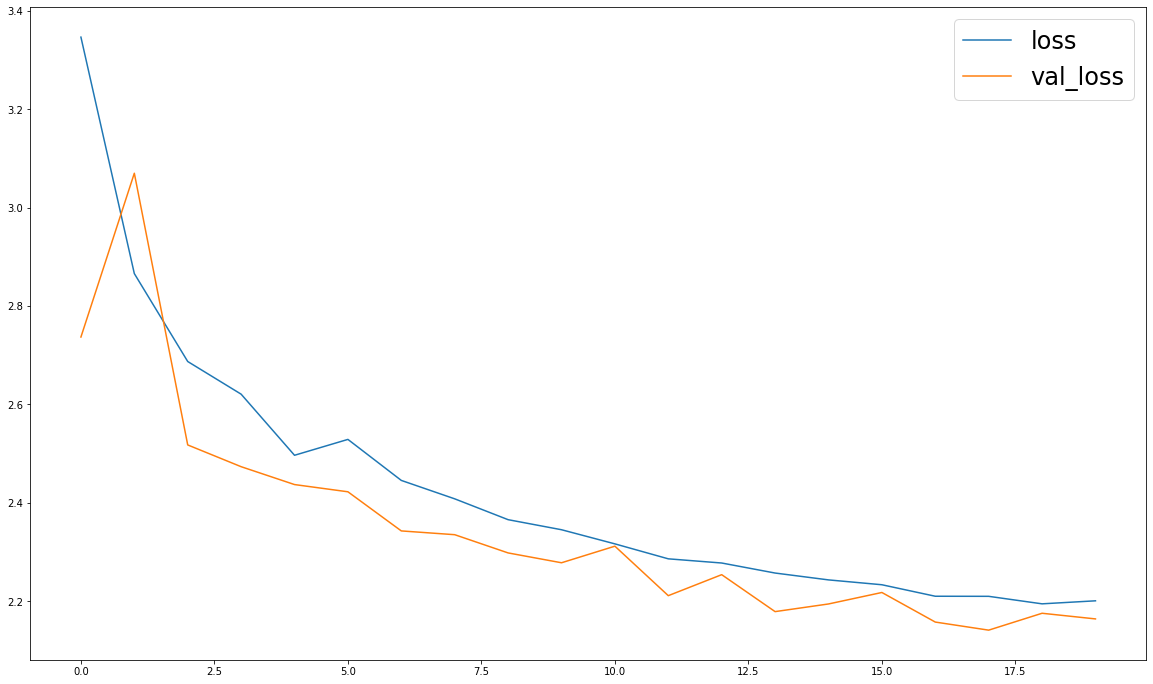

In [8]:
plt.figure(figsize=(20,12))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='upper right', prop={'size': 24});

In [9]:
predict_generator = val_dataset.generate(batch_size=20,
                                         shuffle=True,
                                         transformations=[resize],
                                         label_encoder=None,
                                         returns={'processed_images',
                                                  'filenames',
                                                  'inverse_transform',
                                                  'original_images',
                                                  'original_labels'},
                                         keep_images_without_gt=False)

In [10]:
batch_images, batch_filenames, batch_inverse_transforms, batch_original_images, batch_original_labels = next(predict_generator)

i = 1 # Which batch item to look at

print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(np.array(batch_original_labels[i]))
print(np.array(batch_images[i].shape))

Image: ../../dataset/validation/hammer/img29.jpg

Ground truth boxes:

[[  1  34   5  70 100]
 [  1  34   5  70 100]]
[500 500   3]


In [11]:
y_pred = model.predict(batch_images)
print(y_pred)

[[[ 8.1490731e-01  1.8509264e-01  2.4813488e-03 ...  1.0000000e+00
    1.0000000e+00  1.0000000e+00]
  [ 8.1866896e-01  1.8133105e-01  8.5471449e-03 ...  1.0000000e+00
    1.0000000e+00  1.0000000e+00]
  [ 8.1124765e-01  1.8875234e-01 -3.9092138e-02 ...  1.0000000e+00
    1.0000000e+00  1.0000000e+00]
  ...
  [ 9.1487521e-01  8.5124791e-02 -1.0012985e-02 ...  1.0000000e+00
    1.0000000e+00  1.0000000e+00]
  [ 9.3646330e-01  6.3536718e-02  3.1654947e-02 ...  1.0000000e+00
    1.0000000e+00  1.0000000e+00]
  [ 9.1874385e-01  8.1256136e-02  1.3474243e-02 ...  1.0000000e+00
    1.0000000e+00  1.0000000e+00]]

 [[ 8.2011640e-01  1.7988358e-01 -1.0837747e-02 ...  1.0000000e+00
    1.0000000e+00  1.0000000e+00]
  [ 8.2620627e-01  1.7379373e-01  2.3930972e-03 ...  1.0000000e+00
    1.0000000e+00  1.0000000e+00]
  [ 8.1086409e-01  1.8913591e-01 -2.4360854e-02 ...  1.0000000e+00
    1.0000000e+00  1.0000000e+00]
  ...
  [ 9.0174466e-01  9.8255359e-02  4.3820947e-02 ...  1.0000000e+00
    1.0000

In [12]:
y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.5,
                                   iou_threshold=0.45,
                                   top_k=200,
                                   normalize_coords=normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)
print(y_pred_decoded)

[array([[  1.        ,   0.92268568,  13.27070594,  46.77186906,
        470.18608451, 476.47953033]]), array([[  1.        ,   0.62860286,  68.59439611, -13.49785924,
        464.73646164, 470.39872408]]), array([[  1.        ,   0.60604531,  19.38673854,  81.26755059,
        482.24297166, 525.00146627]]), array([[  1.        ,   0.99169803,  -4.91768122, -37.10827231,
        471.38410807, 484.96237397],
       [  1.        ,   0.65151733,  35.97524762,  15.2259618 ,
        405.0373137 , 304.69685793]]), array([[  1.        ,   0.89482301,  52.17064917,   8.28316808,
        457.03172684, 470.85741162]]), array([[  1.        ,   0.54421073,  -1.7208159 , -29.10849452,
        446.7510879 , 439.6443069 ]]), array([[  1.        ,   0.70106208,  19.60913837,  25.71170032,
        420.92645168, 501.257658  ]]), array([[  1.        ,   0.72174108,  61.43957376,  24.38127995,
        539.54154253, 442.13396311]]), array([[  1.        ,   0.96301687,  64.86599147,  26.69343352,
        49

In [13]:
y_pred_decoded_inv = apply_inverse_transforms(y_pred_decoded, batch_inverse_transforms)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_decoded_inv[i])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[ 1.    0.63 14.   -3.   93.   94.  ]]


In [14]:
print(len(batch_original_images))

20


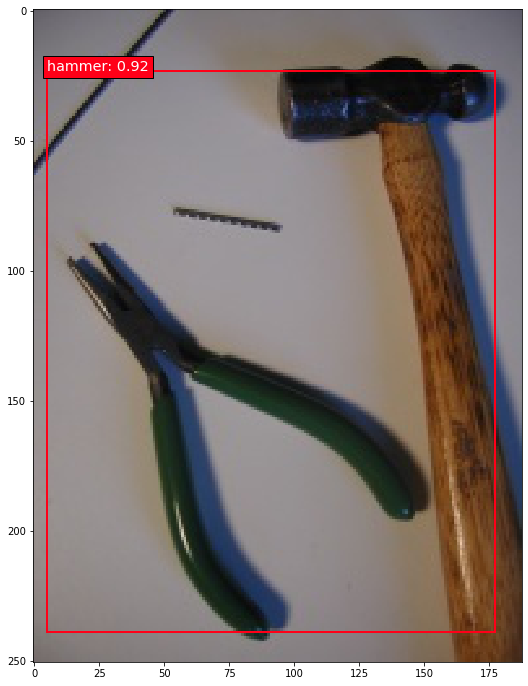

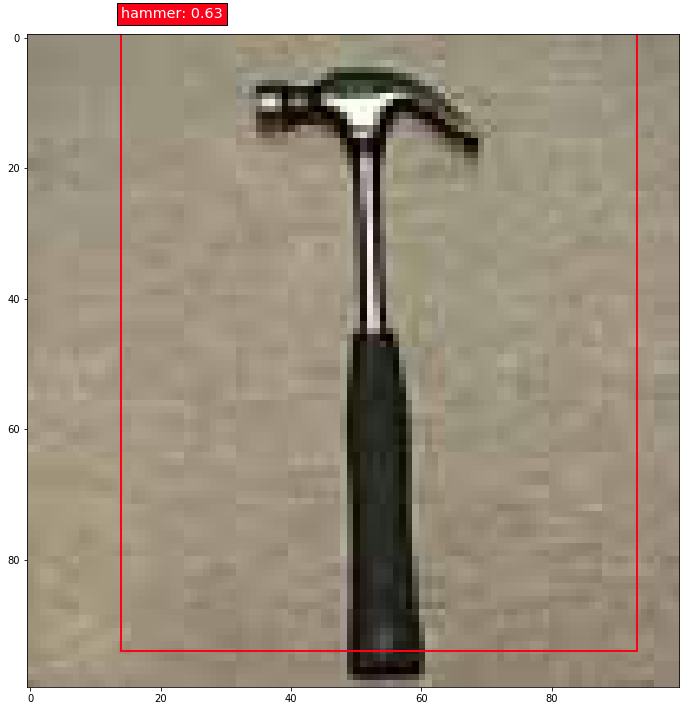

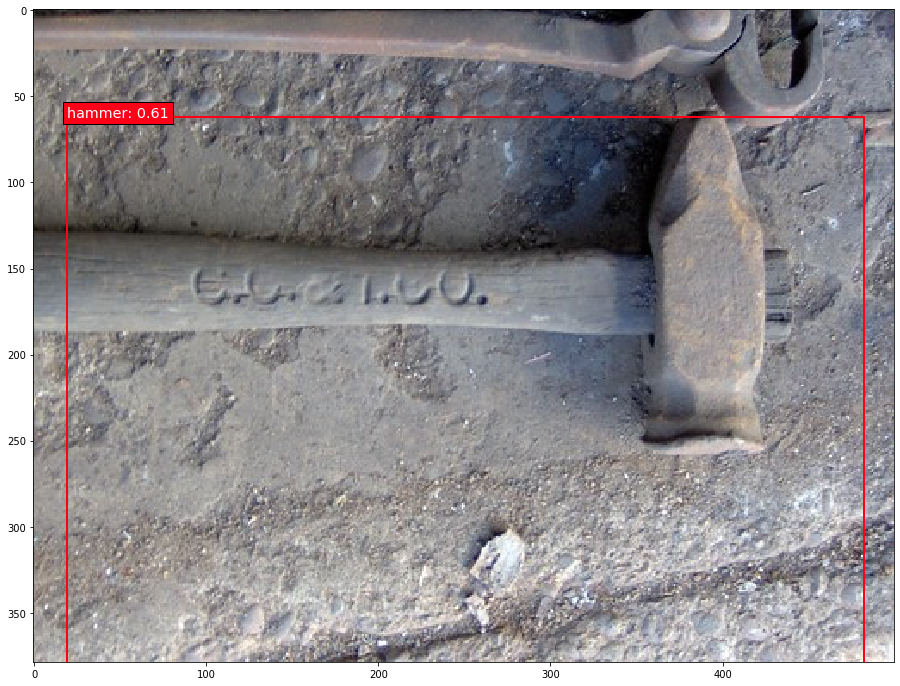

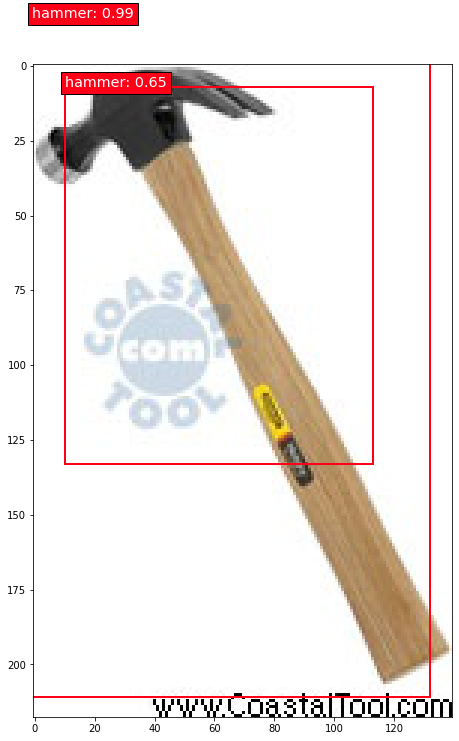

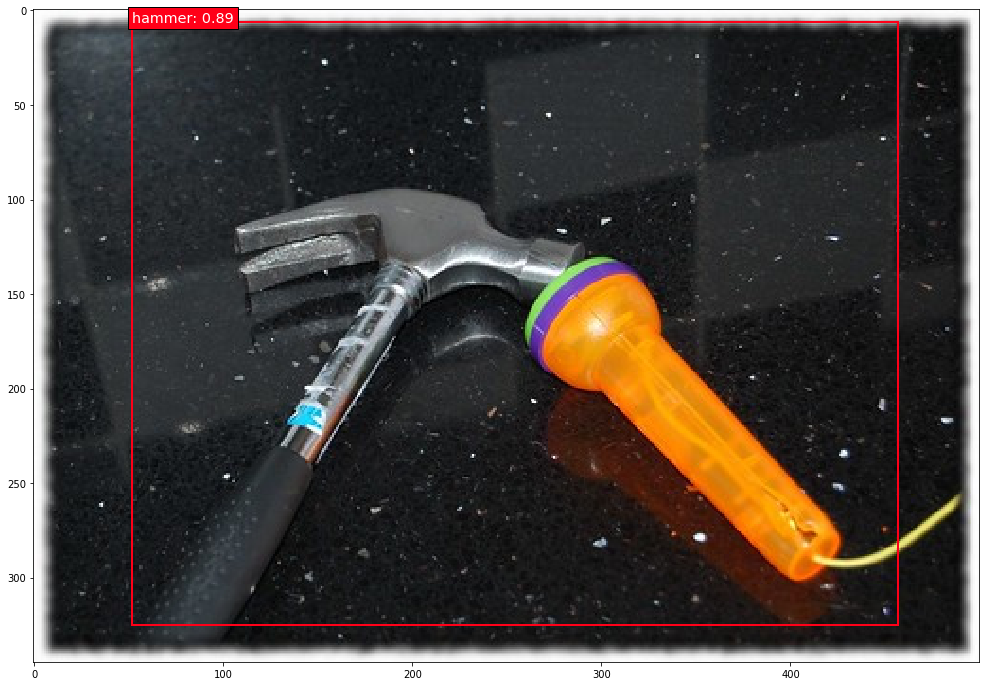

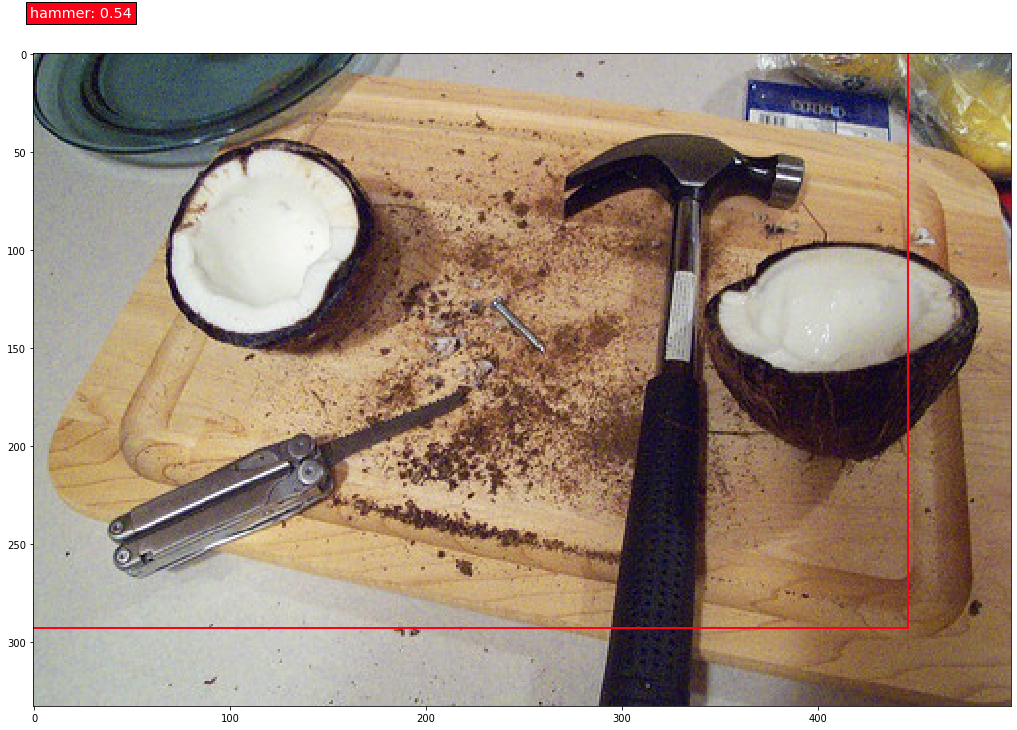

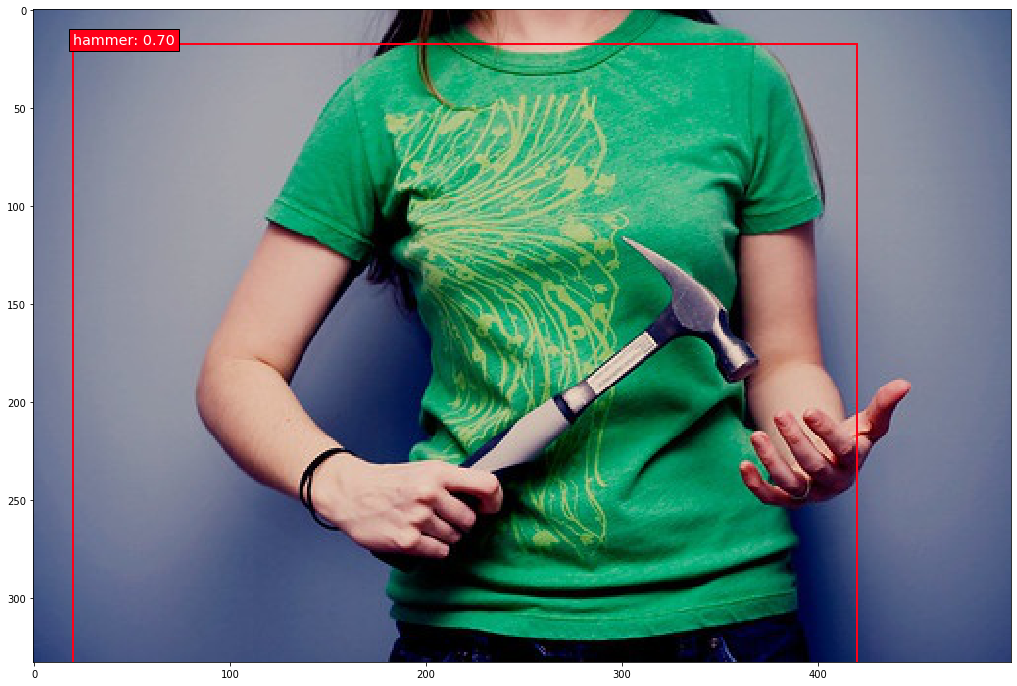

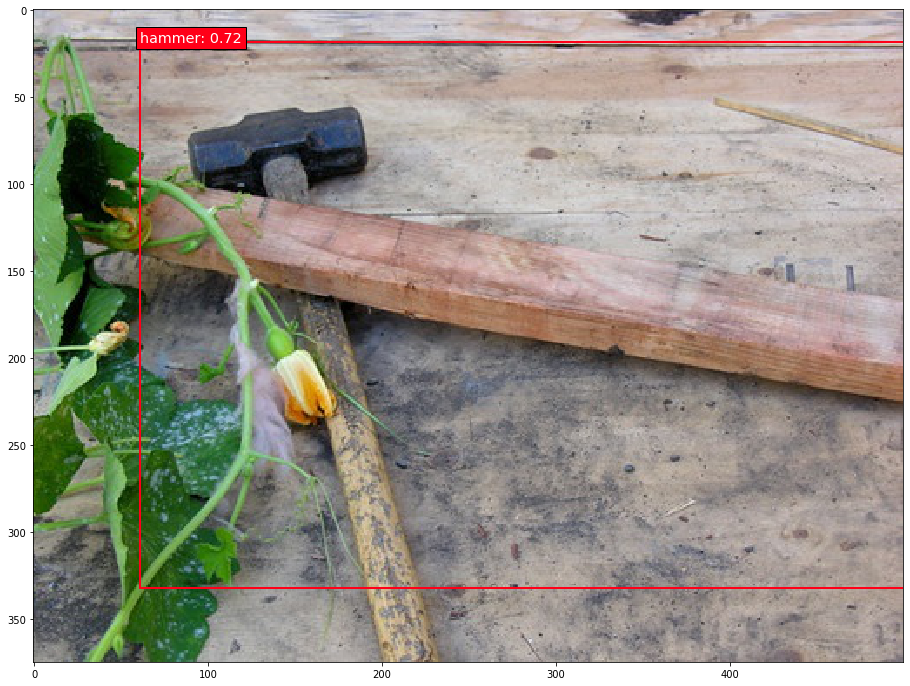

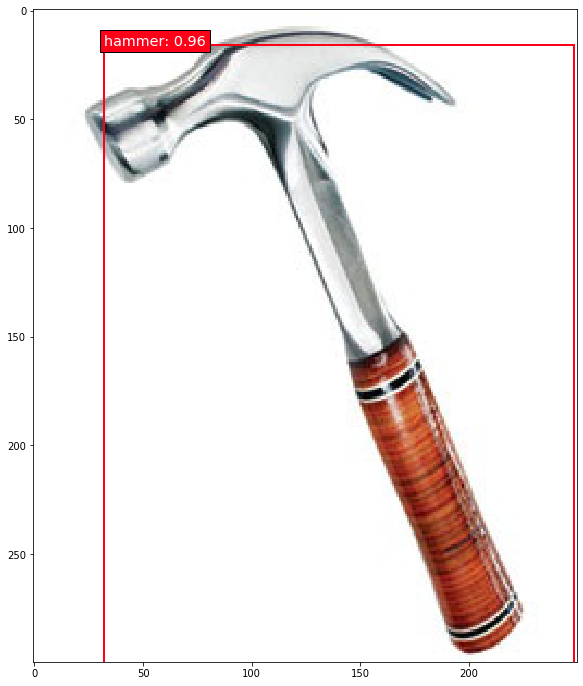

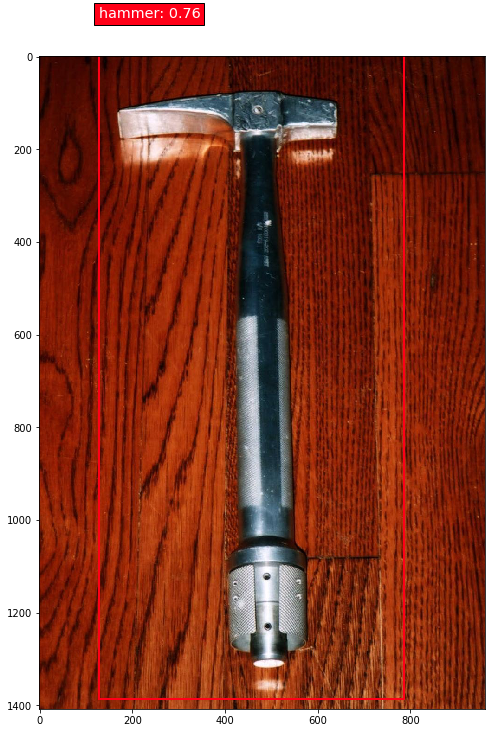

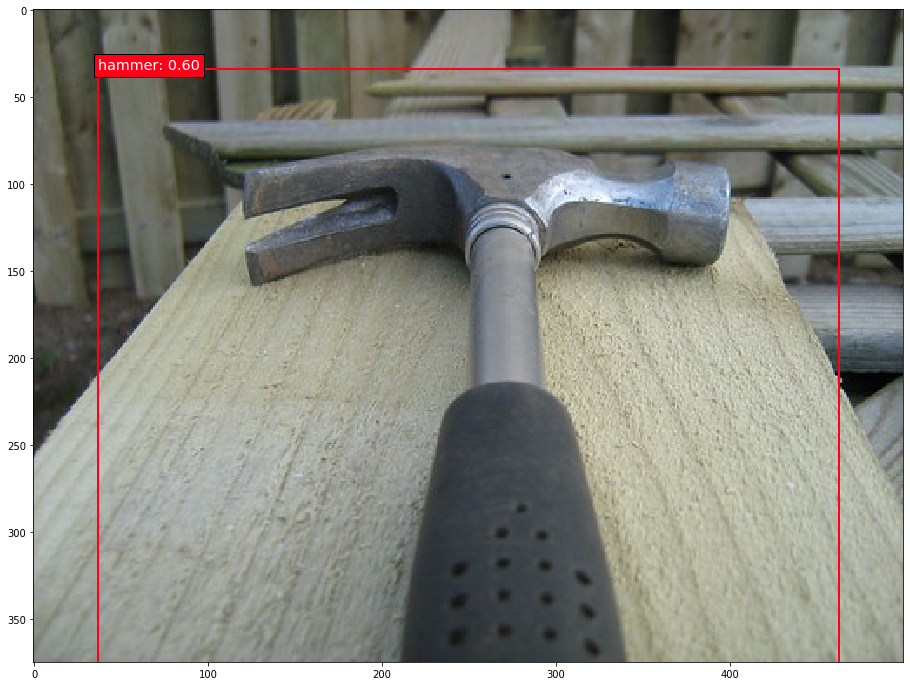

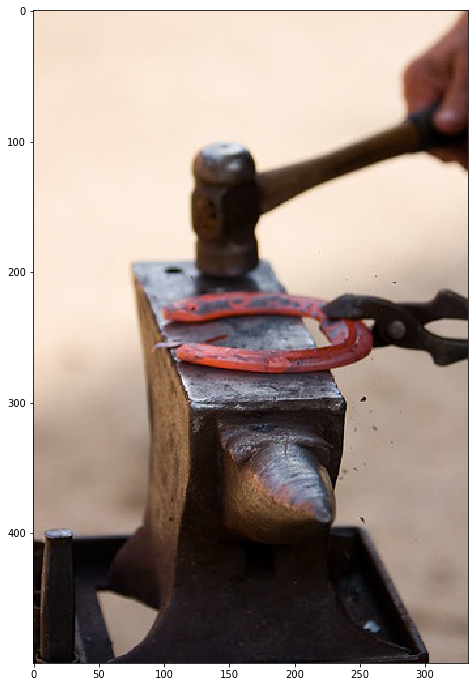

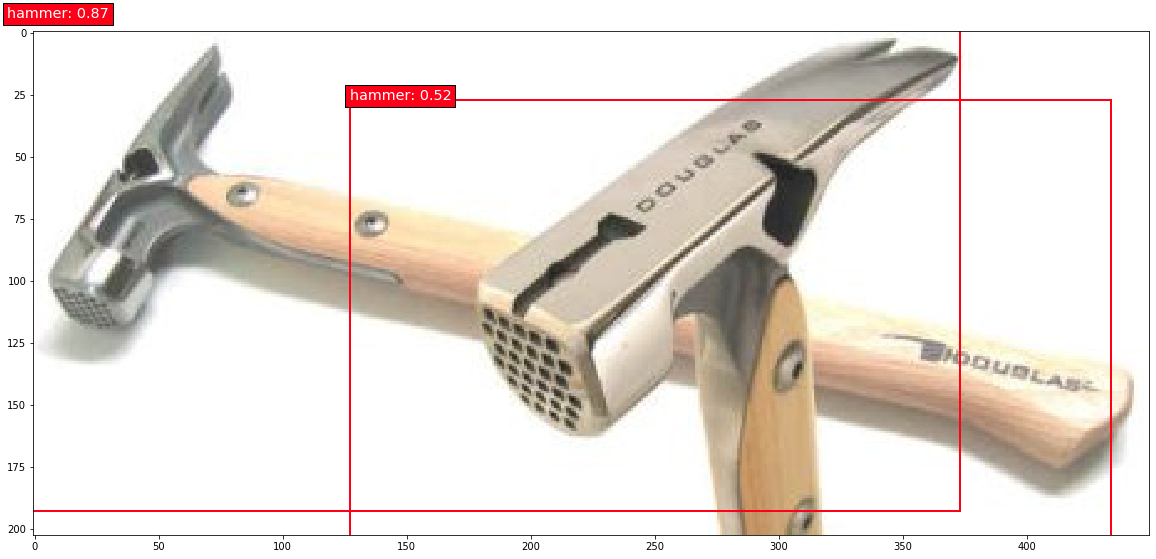

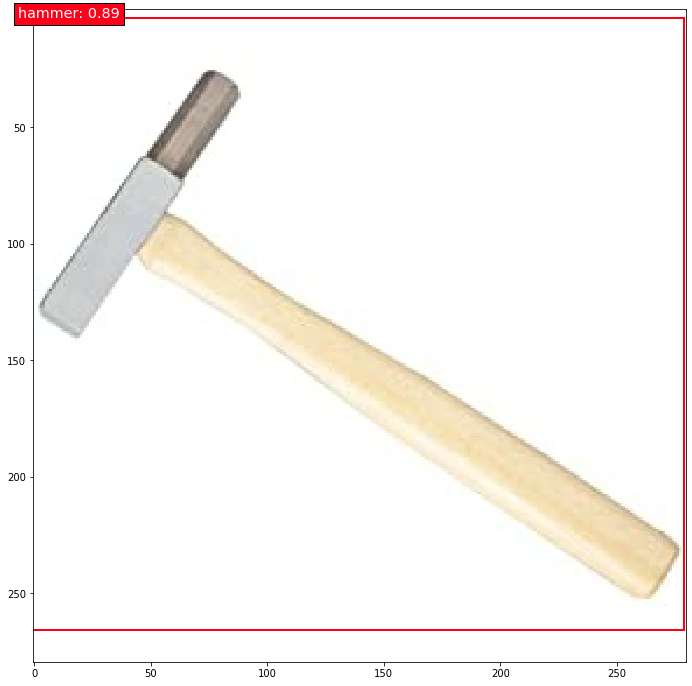

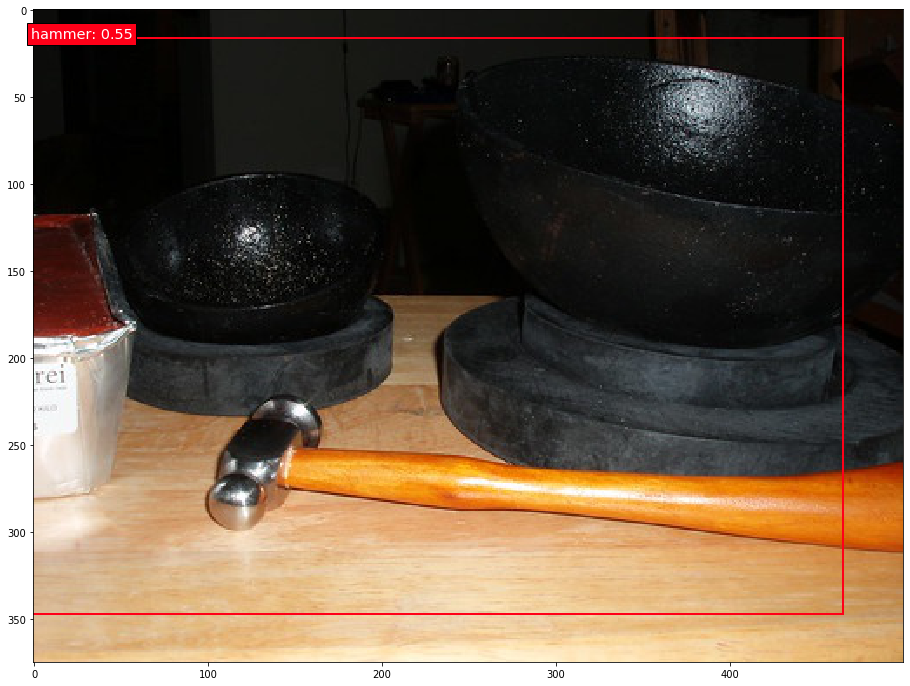

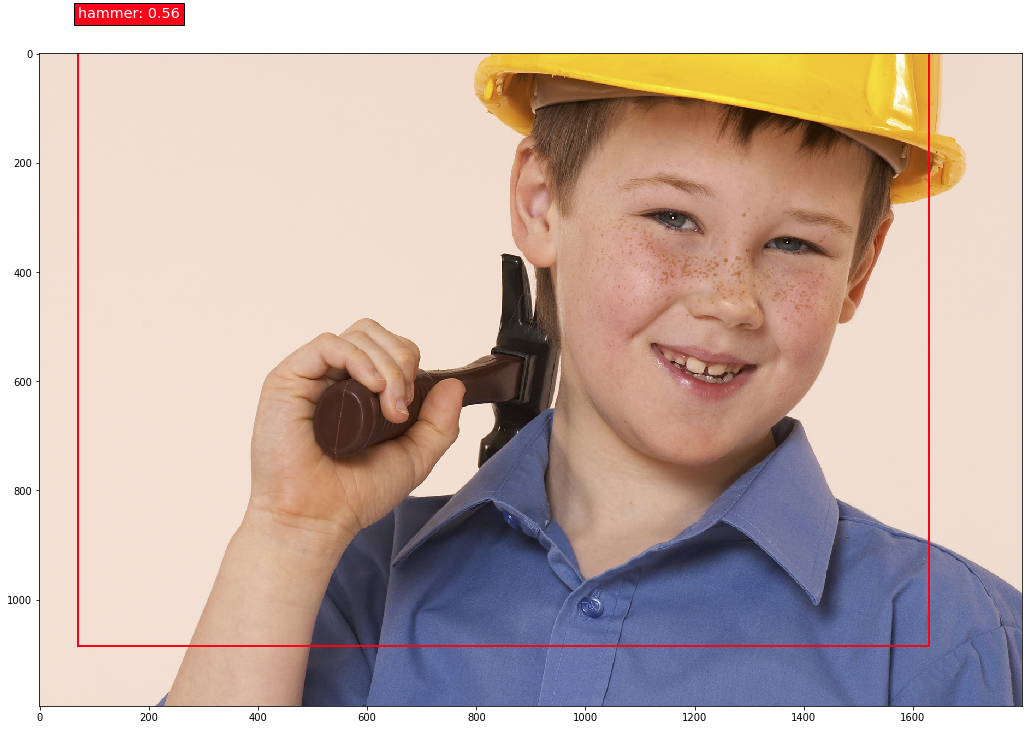

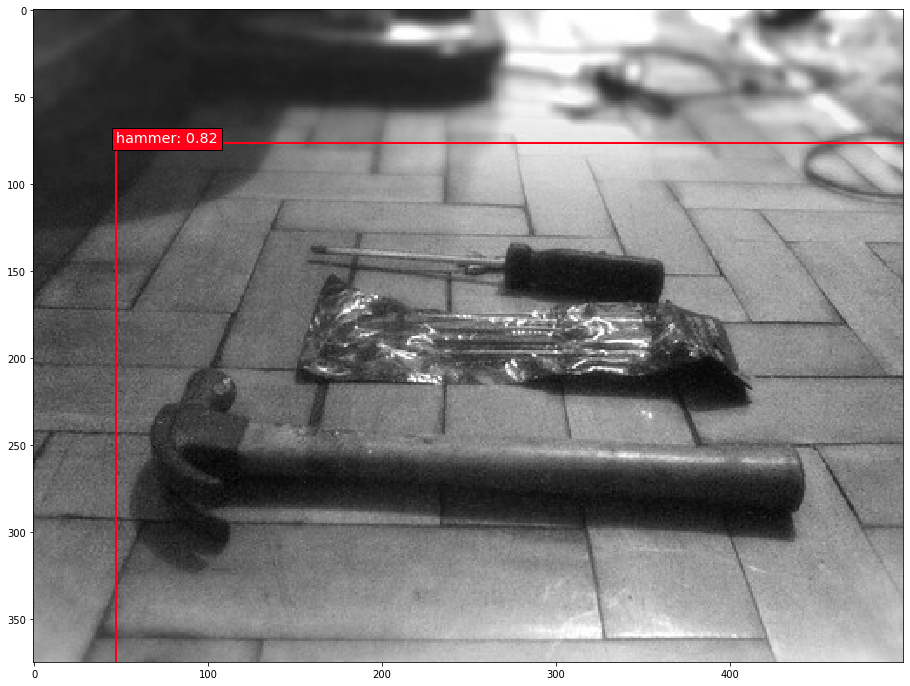

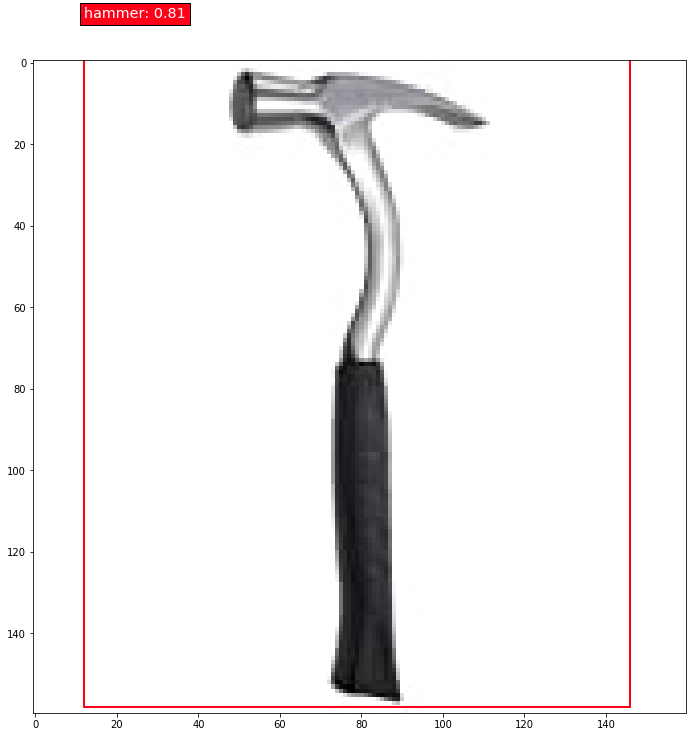

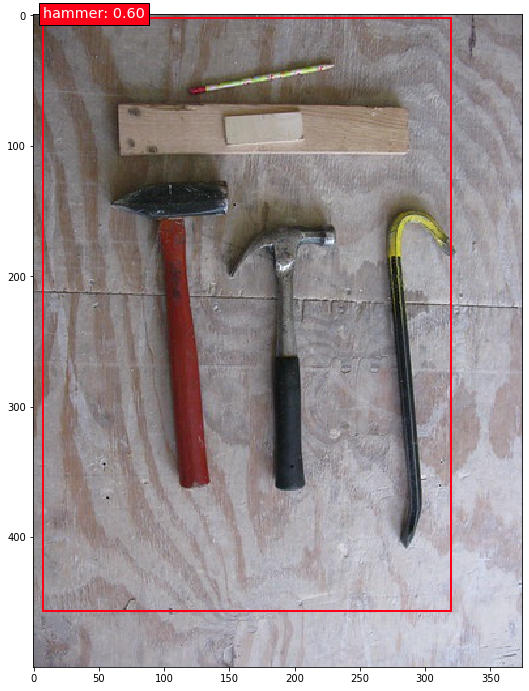

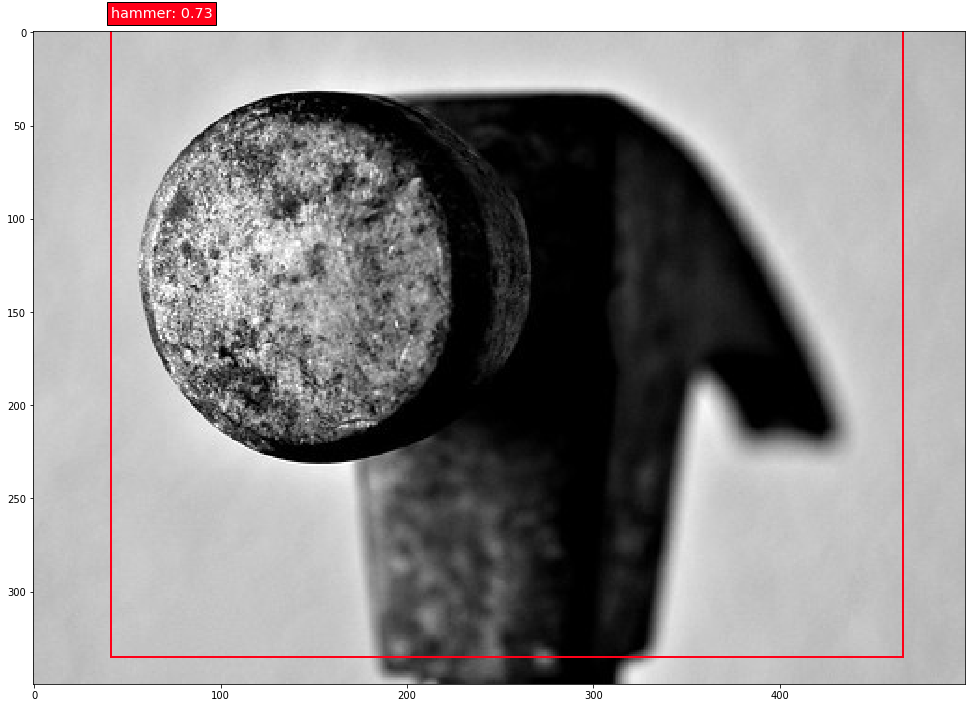

In [15]:
# 5: Draw the predicted boxes onto the image

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist()
classes = ['background','hammer']

for i in range(20):
    plt.figure(figsize=(20,12))
    plt.imshow(batch_original_images[i])

    current_axis = plt.gca()

    for box in y_pred_decoded_inv[i]:
        if box[0] == 1:
            xmin = box[2]
            ymin = box[3]
            xmax = box[4]
            ymax = box[5]
            color = colors[int(box[0])]
            label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
            current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
            current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

In [ ]:
evaluator = Evaluator(model=model,
                      n_classes=n_classes,
                      data_generator=val_dataset,
                      model_mode=model_mode)